# Federal University of Bahia (UFBA)  
## Graduate Program in Geophysics (PPGEOF)  
### Research Group: LIGA - Laboratory of Innovation in Applied Geophysics  

---

**Notebook Title:** *Wiener Filter Tutorial*  
**Author:** *Msc Student. Rômulo Barbosa*  
**Advisor:** *Prof.Dr. Peterson Nogueira Santos*  

**Course:** *Master Degree*

**Line of Research:** *Seismic Imaging*  

**Institution:** *Institute of Geosciences – IGEO/UFBA*  
**Date:** *22/09/2025*  

---

### Objectives  
- This tutorial shows a simple use of the Wiener filter with PyLops to generate filtered seismic data.

---

### Description  

This notebook contains:  

- **Brief summary of what will be done:**  
  - Application of the Wiener filter to seismic data using the PyLops library.

- **Data or models used:**  
  - Marmousi true velocity model loaded from binary file (`model-t.bin`)  

- **Applied methodology:**  
  - Seismic data were generated using the true velocity model with a 2D acoustic wave equation operator (`AcousticWave2D`) from Pylops
  - Ricker wavelets with varying peak frequencies (from 5 Hz to `f_max` Hz)
  - A Wiener filter is applied to filter observed data


## Importing Libraries

In [1]:
import copy
import numpy as np
from utils import *
from wavelets import *

from copy import deepcopy
from pylops.utils import *
from numpy.linalg import norm
import matplotlib.pyplot as plt
from devito import configuration
from pylops.waveeqprocessing.twoway import  AcousticWave2D

configuration['log-level'] = 'ERROR'

## Initializing Model Parameters

The foundation of **Pylops** functionality lies in the use of operators, in this case, the 2D acoustic operator (**AcousticWave2D**). This operator wraps **DEVITO** objects, such as SeismicModel, which includes the velocity model, time step (dt), and other details and Geometry, which contains all the necessary geometry information, such as receiver and source coordinates.

By encapsulating these objects, users only need to focus on the parameters to be applied, rather than on how the underlying objects are built.

Below are the parameters required for creating the **AcousticWave2D** operator.

In [2]:
# Modelling parameters (in meters, seconds and Hz)
par = {
    'nx': 369,   'dx': 25.,    'ox': 2,
    'nz': 375,   'dz': 8.,     'oz': 0,
    'ns': 50,    'ds': 175,    'sz': 1,
    'nr': 369,   'dr': 25,     'rz': 1,
    'nt': 5000,  'dt': 0.0008, 't0': 0.,
    'nw': 30,    'freq': 17
}

shape = (par['nx'], par['nz'])
spacing = (par['dx'], par['dz'])
origin = (par['ox'], par['oz'])
src_type = 'Ricker' # or 'Ricker_Devito' if you want to use Devito Source
dtype = np.float32
space_order = 32
nbl = 40

In [3]:
# Setting model velocity path
path_true_model="data/model-t.bin"

# Loading model velocity
vp = (np.fromfile(path_true_model, np.float32)/1000).reshape(par['nx'], par['nz'])

# Applying water layer
msk = create_mask_value(vp, 1.52)
vp_min = np.min(vp)
vp_max = np.max(vp)

#Applying water mask layer
vp[:, 0:par['nw']] = 1.52

# Setting receivers positions
x_r = np.zeros((par['nr'], 2))
x_r[:, 0] = np.arange(par['nr']) * par['dr'] # receivers positions
x_r[:, 1] = par['rz']

# Setting source positions
x_s = np.zeros((par['ns'], 2))
x_s[:, 0] = np.arange(par['ns']) * par['ds'] # source positions
x_s[:, 1] = par['sz']

# Setting propagation time
t = (np.arange(par['nt'])*par['dt'])
tn = t[-1]

# Creating modelling operator
Dop = AcousticWave2D(shape=shape, origin=origin, spacing=spacing, vp=vp*1e3, nbl=nbl, 
                     space_order=space_order,
                    src_x=x_s[:,0], src_z=x_s[:,1], rec_x=x_r[:,0], rec_z=x_r[:,1], t0=par['t0'], tn=tn*1e3,
                     src_type=src_type, f0=par['freq'], dtype=dtype,op_name="fwd", dt=par['dt']*1e3)

dt = Dop.model.critical_dt
nt = Dop.geometry.nt

vp_true = deepcopy(vp)

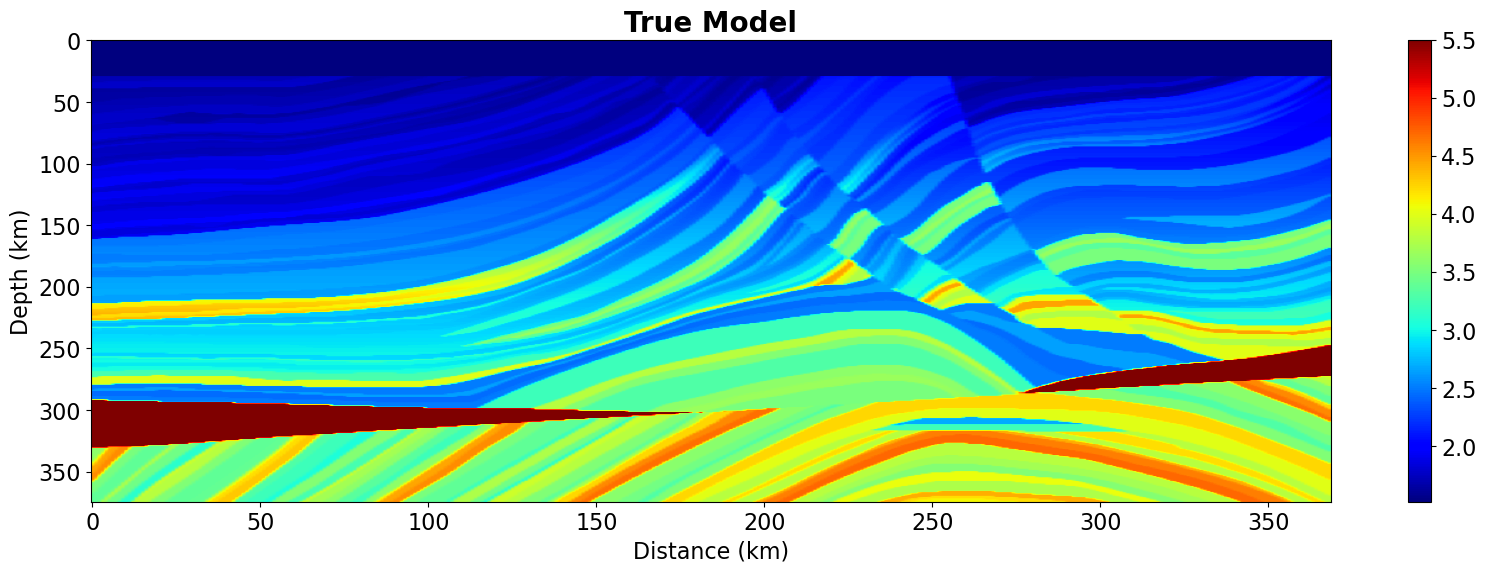

In [4]:
# Plotting velocity models
plt.figure(figsize=(20,6))
plt.imshow(vp_true.T,aspect='auto',cmap='jet')
plt.ylabel('Depth (km)', fontsize=16)
plt.xlabel('Distance (km)',fontsize=16)
plt.title('True Model', fontsize=20, fontweight='bold')
plt.colorbar()

##  Generating Observed Data (Dobs)

Pylops performs forward propagation as follows:

$dobs = Dop * vptrue$, 

where $m$ represents the velocity value $vp$ em m/s.

In [5]:
dobs = Dop * vp_true

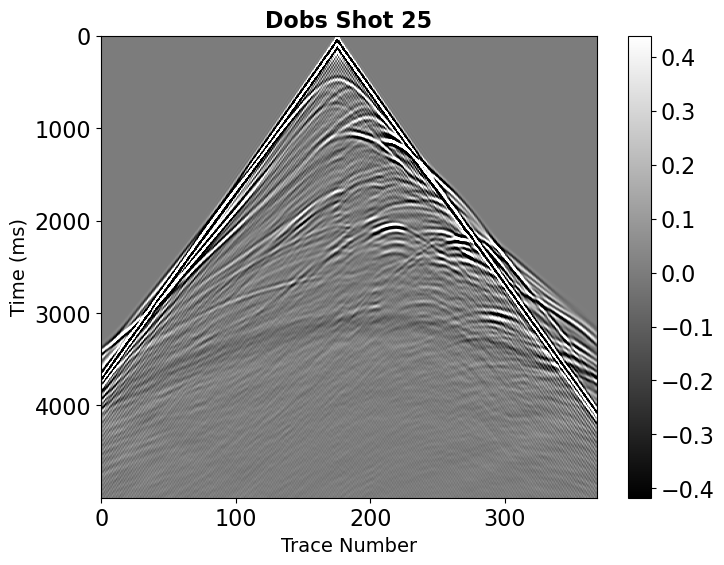

In [7]:
# Plotting Observed Data
shot_dobs = int(par['ns']/2)
plot_data(dobs,shot=shot_dobs, title=f'Dobs Shot {shot_dobs}')

## Generate Target Wavelet

Usually, the target wavelet is obtained by the original wavelet. Nevertheless, in this tutorial the target wavelet will be generated in the same way as original wavelet.

You can choose between Ricker from Devito or Ricker from Fortran to generate your target wavelet. More instructions can be obtained on wavelets.py.

In [8]:
target_wav = Ricker_Devito(shape=shape, spacing=spacing, origin=origin, dt=par['dt'], nt=par['nt'], fpeak=5, t0=par['t0'])

Visualizing the frequency spectrum is important to gain knowledge of the maximum frequency of the wavelet, even for its application in a Multiscale FWI

Peak Frequency: 17 Hz | Max Frequency: 38 Hz


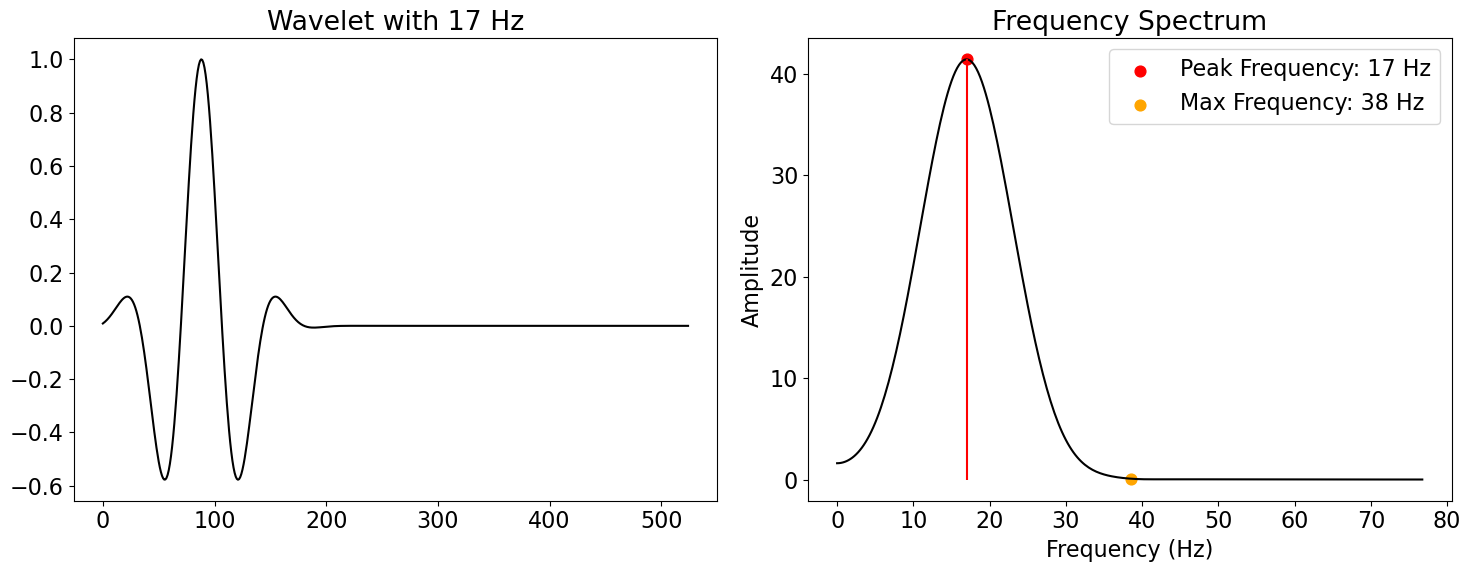

In [9]:
#plotting frequency spectrum for original wavelet
f, amp, f_peak, f_max = Frequency_spectrum(wavelet=Dop.geometry.src.wavelet, dt=par['dt'])

Peak Frequency: 5 Hz | Max Frequency: 20 Hz


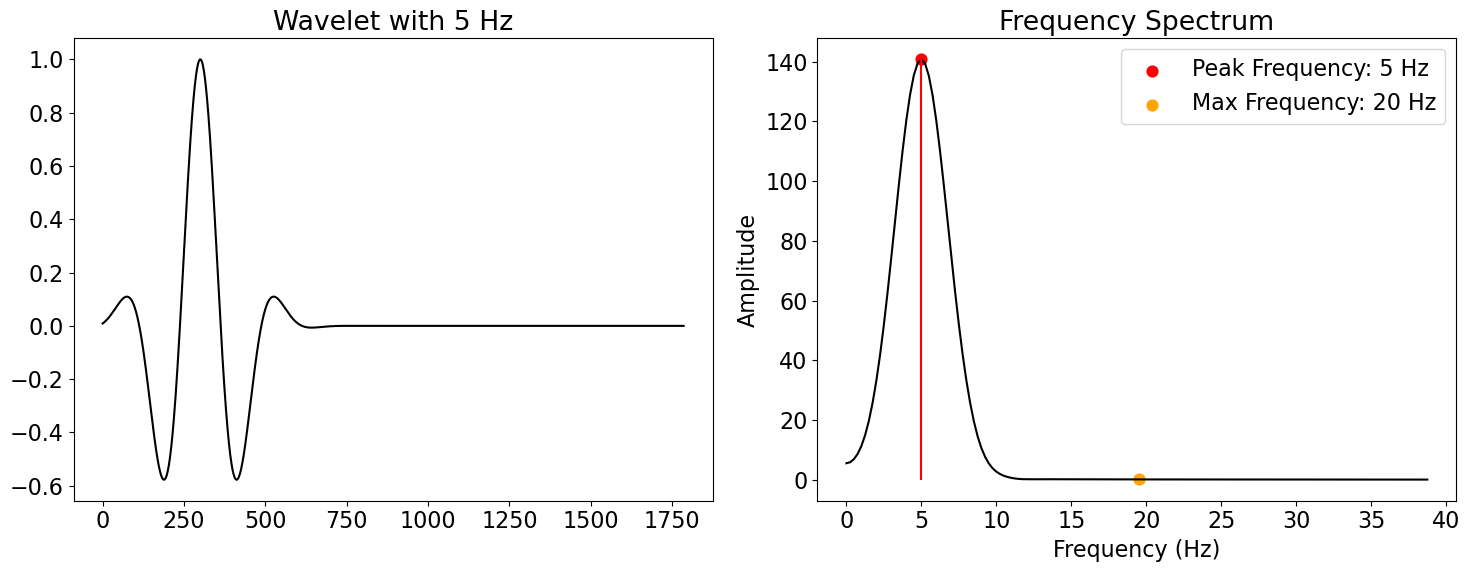

In [10]:
#plotting frequency spectrum for target wavelet
fw, ampw, f_peakw, f_maxw = Frequency_spectrum(target_wav, dt=par['dt'])

## Wiener Filter 

The Wiener filter is a technique that it can filter one signal to
closely match another target signal. On FWI context, the goal is to match the frequency content of a original wavelet to that of a desired wavelet. 

In the frequency domain, the Wiener filter can be written as:

$$
f_{\text{wiener}}(\omega) = \frac{W_{\text{target}}(\omega) \, W_{\text{original}}^*(\omega)}{\left| W_{\text{original}}(\omega) \right|^2 + \epsilon^2},
$$

where:

- $f_{\text{wiener}}(\omega)$ is the frequency response of the Wiener filter,
- $W_{\text{target}}(\omega)$ is the Fourier transform of the target wavelet,
- $W_{\text{original}}(\omega)$ is the Fourier transform of the original wavelet,
- $W_{\text{original}}^*(\omega)$ is the complex conjugate of $W_{\text{original}}(\omega)$,
- $\large{\epsilon}$ is a small regularization parameter to stabilize the division when $|W_{\text{original}}(\omega)|$ is close to zero.


In [12]:
# observed wavelet
wav_orig = Dop.geometry.src.wavelet

# generating wavelets with different frequencies
frequencies = np.arange(3,f_max,3)
list_wav = [Ricker_Devito(shape=shape, spacing=spacing, origin=origin,
                   dt=par['dt'], nt=par['nt'], fpeak=freq, t0=par['t0']) for freq in frequencies]

# generating filtered observed data for each previous frequency
list_dobsfilt = [Wiener_Filt(wav_orig, wav_targ, dobs) for wav_targ in list_wav]

Look how the filtered data became similar to observed data when the frequency used on wiener filter get closer to the observed data frequency.

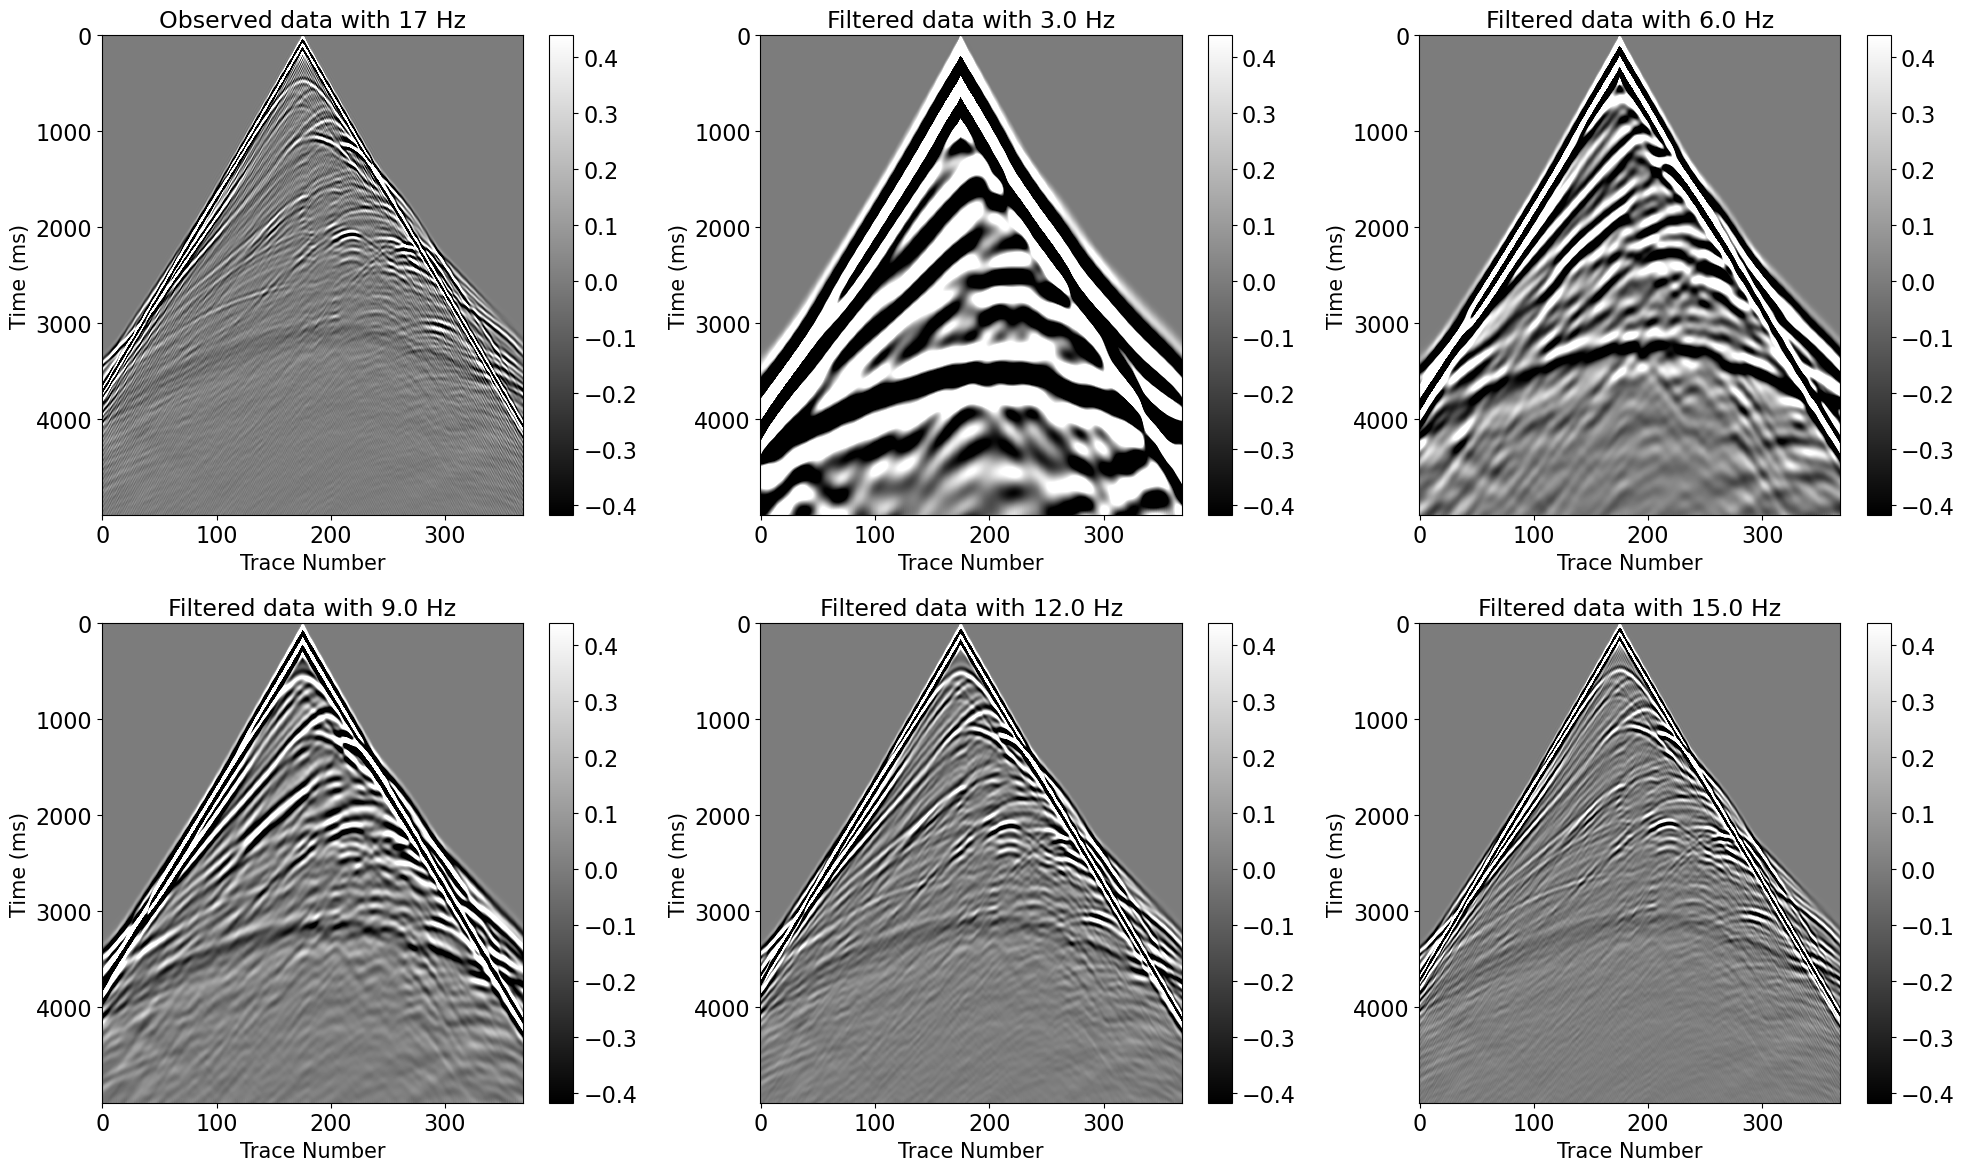

In [13]:
n_rows, n_cols = 2, 3  
num_plots = n_rows * n_cols

# Dados
all_data = [dobs[shot_dobs]] + [filt[shot_dobs] for filt in list_dobsfilt[:num_plots-1]]

vmin, vmax = np.percentile(np.hstack(dobs).ravel(), [2, 98])

titles = [f'Observed data with {par["freq"]} Hz'] + \
         [f'Filtered data with {f} Hz' for f in frequencies[:num_plots-1]]

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 12))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(all_data):
        im = ax.imshow(all_data[i].T, aspect='auto', cmap='gray', vmin=vmin, vmax=vmax)
        ax.set_ylabel('Time (ms)', fontsize=15)
        ax.set_xlabel('Trace Number', fontsize=15)
        ax.set_title(titles[i], fontsize=17)
        plt.colorbar(im, ax=ax)
    else:
        ax.axis('off')  

plt.tight_layout()

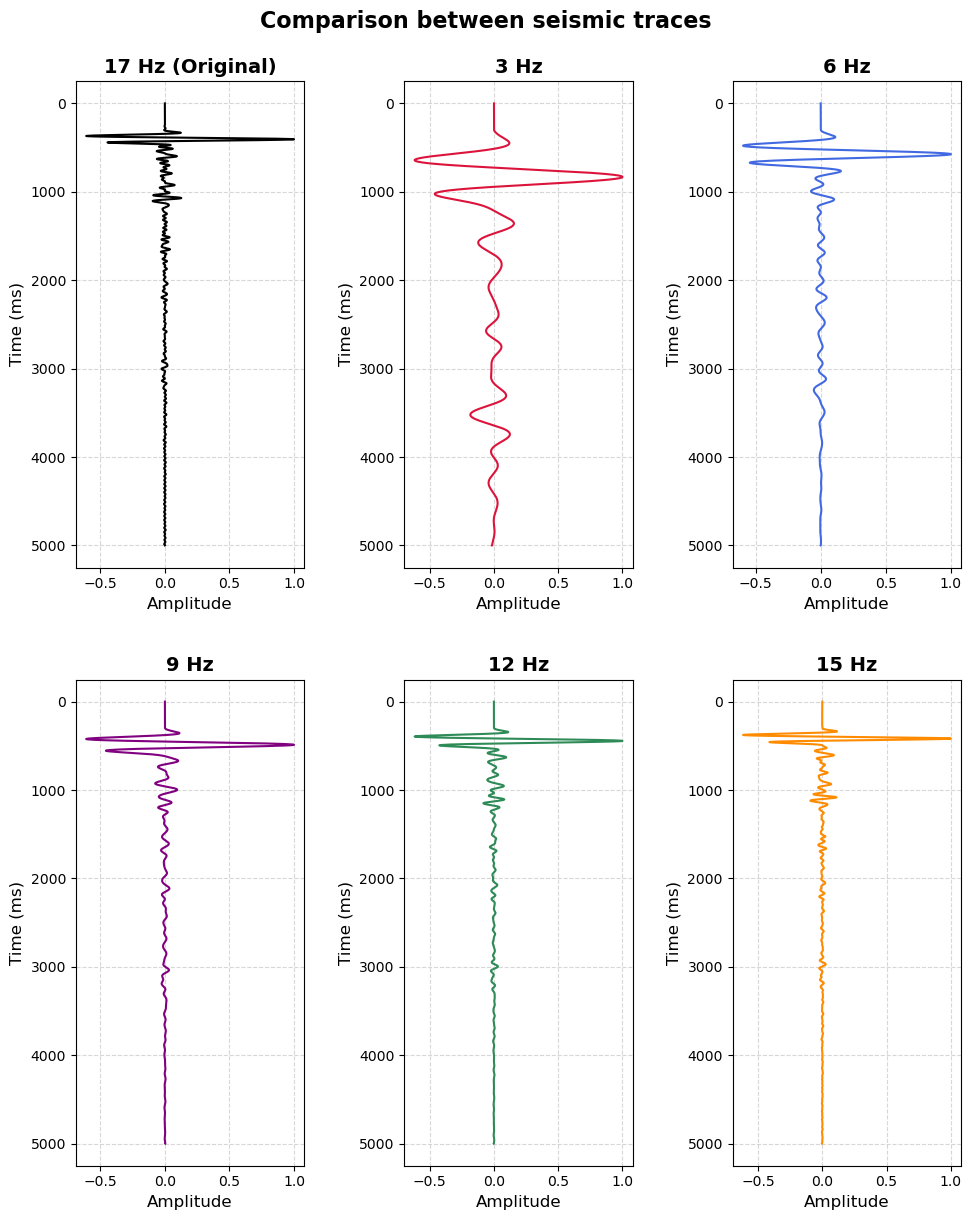

In [14]:
n_samples = len(dobs[shot_dobs][190])
time = np.arange(n_samples)

traces = [
    (dobs[shot_dobs][190], 'black', '17 Hz (Original)'),
    (list_dobsfilt[0][shot_dobs][190], 'crimson', '3 Hz'),
    (list_dobsfilt[1][shot_dobs][190], 'royalblue', '6 Hz'),
    (list_dobsfilt[2][shot_dobs][190], 'purple', '9 Hz'),
    (list_dobsfilt[3][shot_dobs][190], 'seagreen', '12 Hz'),
    (list_dobsfilt[4][shot_dobs][190], 'darkorange', '15 Hz')
]

fig, axs = plt.subplots(2, 3, figsize=(10, 12), dpi=100)
axs = axs.flatten()

normalize = True
if normalize:
    traces = [(trace / np.max(np.abs(trace)), color, title) for trace, color, title in traces]

for i, (trace, color, title) in enumerate(traces):
    axs[i].plot(trace, time, color=color, linewidth=1.5)
    axs[i].invert_yaxis()  # Tempo cresce para baixo
    axs[i].set_title(title, fontsize=14, fontweight='bold')
    axs[i].set_xlabel("Amplitude", fontsize=12)
    axs[i].set_ylabel("Time (ms)", fontsize=12)
    axs[i].grid(True, linestyle='--', alpha=0.5)
    axs[i].tick_params(axis='both', labelsize=10)

plt.tight_layout(h_pad=2.0, w_pad=1.5)

fig.suptitle("Comparison between seismic traces", fontsize=16, fontweight='bold', y=1.02)
plt.show()
